In [2]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import os
import csv
import random
import numpy as np

import time
 
from tqdm import tqdm 

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

from tensorflow.keras import backend as K

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

2025-03-26 17:09:55.545351: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-26 17:09:55.545397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-26 17:09:55.545999: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 17:09:55.550137: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-26 17:09:56.270097: W tensorflow/compiler/tf2

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070, compute capability 8.9


2025-03-26 17:09:57.795444: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-26 17:09:57.830926: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-26 17:09:57.830970: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-26 17:09:57.831314: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
num_classes = 1
k = 5


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]

X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# Definição do diretório de saída
output_dir = "Swin UNet DICE 5-fold model"
os.makedirs(output_dir, exist_ok=True)  # Garante que a pasta existe

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [4]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_)
    mask = (mask >= 250)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask 
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 838/838 [00:19<00:00, 43.00it/s]


In [5]:
@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    """Calcula o F1-Score para segmentação binária"""
    y_pred = K.round(y_pred)  # Arredondar para 0 ou 1
    tp = K.sum(K.cast(y_true * y_pred, 'float32'))  # Verdadeiros Positivos
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'))  # Falsos Positivos
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'))  # Falsos Negativos
    
    precision = tp / (tp + fp + K.epsilon())  # Precision
    recall = tp / (tp + fn + K.epsilon())  # Recall
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1-Score
    return f1

In [6]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D, Dropout, BatchNormalization, ReLU, MaxPooling2D,
    Conv2DTranspose, Concatenate, Reshape, Dense, LayerNormalization,
    MultiHeadAttention, Input, Add
)
from tensorflow.keras.models import Model


window_size = 8


@tf.keras.utils.register_keras_serializable()
class SwinTransformerBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, window_size, shift_size=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size

        self.norm1 = LayerNormalization(epsilon=1e-5)
        self.attn = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=dim // num_heads,
            dropout=0.1,
            use_bias=False  # Reduzir parâmetros
        )
        self.norm2 = LayerNormalization(epsilon=1e-5)
        self.mlp = tf.keras.Sequential([
            Dense(dim * 4, activation='gelu'),
            Dense(dim)
        ])

    def call(self, x):
        input_shape = tf.shape(x)
        B, H, W, C = input_shape[0], input_shape[1], input_shape[2], input_shape[3]
        
        # Window shifting
        if self.shift_size > 0:
            shifted_x = tf.roll(x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2])
        else:
            shifted_x = x
            
        # Window partitioning
        x_windows = self.window_partition(shifted_x)
        
        # Multi-head self-attention
        attn_windows = self.attn(x_windows, x_windows)
        
        # Merge windows
        shifted_x = self.window_merge(attn_windows, H, W, C)
        
        # Reverse window shifting
        if self.shift_size > 0:
            x = tf.roll(shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2])
        else:
            x = shifted_x
            
        # Residual connection e normalização
        x = x + self.norm1(x)
        
        # MLP
        x = x + self.mlp(self.norm2(x))
        
        return x

    def window_partition(self, x):
        B = tf.shape(x)[0]
        H = tf.shape(x)[1]
        W = tf.shape(x)[2]
        C = tf.shape(x)[3]
        
        x = tf.reshape(
            x,
            [-1, H//self.window_size, self.window_size, W//self.window_size, self.window_size, C]
        )
        x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
        x = tf.reshape(x, [-1, self.window_size, self.window_size, C])
        return x

    def window_merge(self, x, H, W, C):  # Adicionado C como parâmetro
        B = tf.shape(x)[0] // ((H * W) // (self.window_size ** 2))
        x = tf.reshape(
            x,
            [B, H//self.window_size, W//self.window_size, self.window_size, self.window_size, C]
        )
        x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
        x = tf.reshape(x, [B, H, W, C])
        return x

def swin_unet():
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Encoder
    c1 = Conv2D(16, 3, padding='same')(inputs)
    c1 = SwinTransformerBlock(16, 4, window_size)(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, 3, padding='same')(p1)
    c2 = SwinTransformerBlock(32, 8, window_size)(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, 3, padding='same')(p2)
    c3 = SwinTransformerBlock(64, 16, window_size)(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(128, 3, padding='same')(p3)
    c4 = SwinTransformerBlock(128, 16, window_size, shift_size=4)(c4)
    
    # Decoder (Ajustar as dimensões dos blocos Swin)
    u1 = Conv2DTranspose(64, 2, strides=2, padding='same')(c4)
    u1 = Concatenate()([u1, c3])  # 64 + 64 = 128 canais
    u1 = SwinTransformerBlock(128, 16, window_size)(u1)  # Dim deve corresponder aos canais de entrada
    
    u2 = Conv2DTranspose(32, 2, strides=2, padding='same')(u1)
    u2 = Concatenate()([u2, c2])  # 32 + 32 = 64 canais
    u2 = SwinTransformerBlock(64, 8, window_size)(u2)  # Ajustar para 64 canais
    
    u3 = Conv2DTranspose(16, 2, strides=2, padding='same')(u2)
    u3 = Concatenate()([u3, c1])  # 16 + 16 = 32 canais
    u3 = SwinTransformerBlock(32, 4, window_size)(u3)  # Ajustar para 32 canais
    
    outputs = Conv2D(num_classes, 1, activation='sigmoid')(u3)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss=dice_loss, metrics=[
        'accuracy', 
        tf.keras.metrics.Recall(name='recall'), 
        tf.keras.metrics.Precision(name='precision'),
        f1_score
        #tf.keras.metrics.IoU(num_classes=2, target_class_ids={0,1}, name='IoU')
    ])
    return model

In [7]:
acc = []
jacc = []
f1 = []
prec = []
rec = []

# Dicionário para armazenar métricas por fold
fold_metrics_summary = []

kf = KFold(n_splits=k, shuffle=True, random_state=28)
fold = 1

for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i < (fold-1):
        continue
    
    
    print("Fold: " + str(fold))
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    model = swin_unet()
    
    
    checkpoint_filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir='logs'),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=False,
                monitor='val_f1_score',
                mode='max',
                save_best_only=True,
                verbose=1)]
    
    start_time = time.time()
    model.fit(X_train, y_train, validation_data=(X_val,y_val), batch_size=2, epochs=150, callbacks=callbacks)
    end_time = time.time()
    training_time = end_time - start_time

     # Salvando o tempo de treinamento
    with open(os.path.join(output_dir, 'training_time.txt'), 'a') as f:
        f.write(f'Fold {fold}: {training_time:.2f} segundos\n')
    print(f"O modelo demorou {training_time:.2f} segundos para treinar.")
    
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    
    with open(os.path.join(output_dir, f'loss_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Epoch", "Loss", "Validation Loss"])
        for epoch, (l, vl) in enumerate(zip(loss, val_loss), start=1):
            writer.writerow([epoch, l, vl])
            
     # Plotando e salvando a figura
    plt.figure()
    plt.plot(loss, 'r', label='Training loss')
    plt.plot(val_loss, 'g', label='Validation loss')
    plt.title(f'Training and Validation Loss - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'loss_plot_fold{fold}.png'))
    plt.close()


    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])

        
    del model 

    tf.keras.backend.clear_session()

    fold+=1
    
# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

Fold: 1


2025-03-25 18:16:02.890253: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 18:16:02.890321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 18:16:02.890338: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 18:16:02.986320: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-25 18:16:02.986362: I external/local_xla/xla/stream_executor

Epoch 1/150


2025-03-25 18:16:11.448255: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-03-25 18:16:14.314309: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f6884003510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-25 18:16:14.314340: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-03-25 18:16:14.321518: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742937374.436679  326837 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


335/335 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.2036 - recall: 0.5608 - precision: 4.3539e-04 - f1_score: 8.7219e-04
Epoch 1: val_f1_score improved from -inf to 0.00145, saving model to Swin UNet DICE 5-fold model/model_1fold.keras
335/335 [==============================] - 106s 279ms/step - loss: 1.0000 - accuracy: 0.2036 - recall: 0.5608 - precision: 4.3539e-04 - f1_score: 8.7219e-04 - val_loss: 1.0000 - val_accuracy: 0.0901 - val_recall: 0.9976 - val_precision: 7.3034e-04 - val_f1_score: 0.0015
Epoch 2/150
335/335 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.2035 - recall: 0.5442 - precision: 4.2246e-04 - f1_score: 8.4621e-04
Epoch 2: val_f1_score did not improve from 0.00145
335/335 [==============================] - 92s 275ms/step - loss: 1.0000 - accuracy: 0.2035 - recall: 0.5442 - precision: 4.2246e-04 - f1_score: 8.4621e-04 - val_loss: 1.0000 - val_accuracy: 0.0901 - val_recall: 0.9976 - val_precision: 7.3034e-04 - val_

2025-03-25 22:05:46.767118: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 702545920 exceeds 10% of free system memory.
2025-03-25 22:05:47.072403: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 702545920 exceeds 10% of free system memory.


Epoch 1/150
335/335 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.5237 - recall: 0.9765 - precision: 0.0013 - f1_score: 0.0025
Epoch 1: val_f1_score improved from -inf to 0.00258, saving model to Swin UNet DICE 5-fold model/model_2fold.keras
335/335 [==============================] - 103s 277ms/step - loss: 1.0000 - accuracy: 0.5237 - recall: 0.9765 - precision: 0.0013 - f1_score: 0.0025 - val_loss: 1.0000 - val_accuracy: 0.5115 - val_recall: 0.9918 - val_precision: 0.0014 - val_f1_score: 0.0026
Epoch 2/150
335/335 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.5235 - recall: 0.9771 - precision: 0.0013 - f1_score: 0.0025
Epoch 2: val_f1_score did not improve from 0.00258
335/335 [==============================] - 92s 274ms/step - loss: 1.0000 - accuracy: 0.5235 - recall: 0.9771 - precision: 0.0013 - f1_score: 0.0025 - val_loss: 1.0000 - val_accuracy: 0.5115 - val_recall: 0.9918 - val_precision: 0.0014 - val_f1_score: 0.0026
Epoch 3/150

2025-03-26 01:55:27.499114: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 702545920 exceeds 10% of free system memory.


Epoch 1/150
335/335 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.3442 - recall: 0.9834 - precision: 9.4243e-04 - f1_score: 0.0019
Epoch 1: val_f1_score improved from -inf to 0.00187, saving model to Swin UNet DICE 5-fold model/model_3fold.keras
335/335 [==============================] - 103s 278ms/step - loss: 1.0000 - accuracy: 0.3442 - recall: 0.9834 - precision: 9.4243e-04 - f1_score: 0.0019 - val_loss: 1.0000 - val_accuracy: 0.3397 - val_recall: 0.9837 - val_precision: 9.2840e-04 - val_f1_score: 0.0019
Epoch 2/150
335/335 [==============================] - ETA: 0s - loss: 1.0000 - accuracy: 0.3441 - recall: 0.9836 - precision: 9.4246e-04 - f1_score: 0.0019
Epoch 2: val_f1_score did not improve from 0.00187
335/335 [==============================] - 92s 273ms/step - loss: 1.0000 - accuracy: 0.3441 - recall: 0.9836 - precision: 9.4246e-04 - f1_score: 0.0019 - val_loss: 1.0000 - val_accuracy: 0.3397 - val_recall: 0.9837 - val_precision: 9.2840e-04 - val_f1_s

In [8]:
acc_mean_fold = []
jacc_mean_fold = []
f1_mean_fold = []
prec_mean_fold = []
rec_mean_fold = []

acc_std_fold = []
jacc_std_fold = []
f1_std_fold = []
prec_std_fold = []
rec_std_fold = []


# Dicionário para armazenar métricas por fold
fold_metrics_summary = []

fold = 1
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for train_ind, test_ind in tqdm(kf.split(X), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    model_filepath = filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    model = tf.keras.models.load_model(model_filepath)

    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])


    fold += 1

# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

k-fold: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [02:36<00:00, 31.22s/it]

Métricas salvas com sucesso na pasta: Swin UNet DICE 5-fold model


In [9]:
print("Accuracy: "+ str(np.mean(acc_total)*100) + " +- " + str(np.std(acc_total)*100))
print("Jaccard: "+ str(np.mean(jacc_total)*100) + " +- " + str(np.std(jacc_total)*100))
print("Dice: "+ str(np.mean(f1_total)*100) + " +- " + str(np.std(f1_total)*100))
print("Precision: "+ str(np.mean(prec_total)*100) + " +- " + str(np.std(prec_total)*100))
print("Recall: "+ str(np.mean(rec_total)*100) + " +- " + str(np.std(rec_total)*100))

Accuracy: 35.22233842817643 +- 16.236503238477354
Jaccard: 0.0761364186862522 +- 0.03827821998435696
Dice: 0.1519643934443593 +- 0.07633839850313962
Precision: 0.0761461816570314 +- 0.038270436507616676
Recall: 79.88952671695196 +- 35.1157563085632


In [10]:
best_fold = 2
best_model_filepath = filepath = os.path.join(output_dir, f'model_{best_fold}fold.keras')
best_model = tf.keras.models.load_model(best_model_filepath)

In [11]:
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i == (best_fold-1):
        X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
        break

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()
  

1/1 [==============================] - 0s 117ms/step


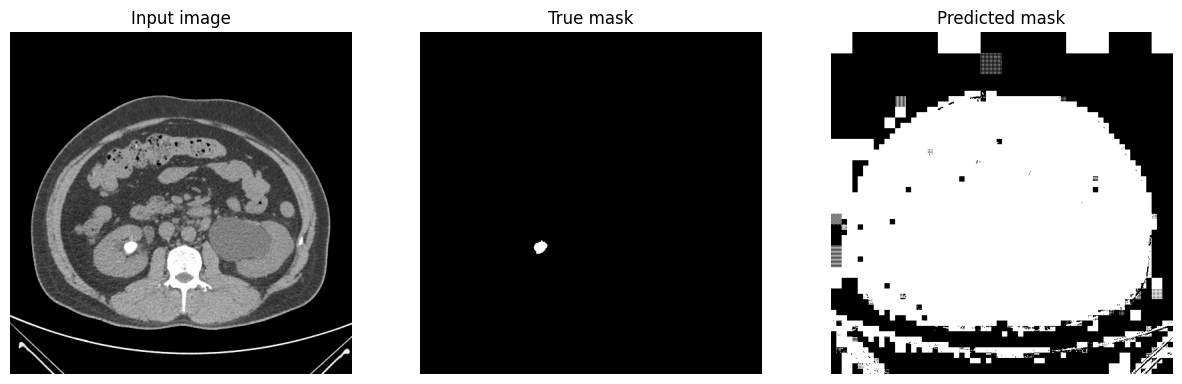

Accuracy: 0.39239501953125
Jaccard: 0.001704773365423185
Dice: 0.003403744118530383
Precision: 0.001704773365423185
Recall: 1.0


In [15]:
i = random.randint(0, len(X_val))
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = best_model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

sample_mask = y_val[i].astype(np.uint8).flatten()
predicted_mask = predicted_mask.flatten()


print("Accuracy: "+ str(accuracy_score(sample_mask, predicted_mask)))
print("Jaccard: "+ str(jaccard_score(sample_mask, predicted_mask)))
print("Dice: "+ str((2*jaccard_score(sample_mask, predicted_mask))/(1+jaccard_score(sample_mask, predicted_mask))))
print("Precision: "+ str(precision_score(sample_mask, predicted_mask)))
print("Recall: "+ str(recall_score(sample_mask, predicted_mask)))

In [8]:
model = swin_unet()
model.summary()

2025-03-26 17:10:17.375991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-26 17:10:17.376056: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-26 17:10:17.376072: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-26 17:10:17.484978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-26 17:10:17.485033: I external/local_xla/xla/stream_executor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 16)         160       ['input_1[0][0]']             
                                                                                                  
 swin_transformer_block (Sw  (None, 512, 512, 16)         3216      ['conv2d[0][0]']              
 inTransformerBlock)                                                                              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 256, 256, 16)         0         ['swin_transformer_block[0